In [14]:
import os
import torch
import cv2
import pandas as pd

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, folder_path, labels_df, labels_to_index, transforms=None):
        self.folder_path = folder_path
        self.labels_df = labels_df
        self.labels_to_index = labels_to_index
        self.transforms = transforms #Augmentation and ToTensor
    
    def __getitem__(self, index):
        '''Read index image + label and return it'''
        input_data = self.labels_df.loc[index, :]
        image = cv2.imread(os.path.join(self.folder_path, input_data['image_name']),
        cv2.IMREAD_UNCHANGED) #Read image
        label = self.labels_to_index[input_data['label']] #Change label to number
        if self.transforms:
            image = self.transforms(image) #Run given transformations / augmentations
        
        return image, label
    def __len__(self):
        return len(self.labels)


In [4]:
training_labels = pd.read_csv('./CIFAR-10/training_labels.csv')
training_labels

,image_name,label
0,0.jpg,frog
1,1.jpg,truck
2,2.jpg,truck
3,3.jpg,deer
4,4.jpg,automobile
...,...,...
49995,49995.jpg,bird
49996,49996.jpg,frog
49997,49997.jpg,truck
49998,49998.jpg,automobile


In [6]:
training_df = training_labels.loc[0:int(0.7*len(training_labels)), :]
validation_df = training_labels.loc[int(0.7*len(training_labels)) + 1::, :]

training_df.to_csv('real_train.csv', index=False)
validation_df.to_csv('real_val.csv', index=False)


In [9]:
labels2index = {name : index for index, name in enumerate(pd.unique(training_df['label']))}

In [15]:
training_folder = './CIFAR-10/train/'
training_dataset = CustomDataset(training_folder, training_df, labels2index)
validation_dataset = CustomDataset(training_folder, validation_df, labels2index)


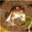

In [19]:
from PIL import Image

Image.fromarray(training_dataset[0][0])

In [20]:
training_dataset[0][1]

0

In [82]:
import json

with open('./CIFAR-10/labels2index.json', 'w') as f:
    json.dump(labels2index, f)

In [50]:
from torch import nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, nb_classes, n_channels, img_size=(255, 255)):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=n_channels, out_channels=64,
                               kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64,
                               kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64,
                               kernel_size=5, padding=2)
        self.max_pool = nn.MaxPool2d((2, 2), stride=2)
        vector_size = img_size[0] // 2 * img_size[1] // 2 * 64
        self.fc = nn.Linear(vector_size, nb_classes)
        self.nb_classes = nb_classes
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.max_pool(x)
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(len(x), -1)
        x = self.dropout(x)
        return self.fc(x)

    @torch.no_grad()
    def get_all_features(self, x):
        conv1 = F.relu(self.conv1(x))
        max_pool = self.max_pool(conv1)
        conv2 = F.relu(self.conv2(max_pool))
        conv3 = F.relu(self.conv3(conv2))
        flatten = conv3.view(len(conv3), -1)
        dropout = self.dropout(flatten)
        fc = self.fc(dropout)
        return [conv1, max_pool, conv2, conv3, flatten, dropout, fc]

In [51]:
model = SimpleCNN(10, 3, (32, 32))

In [45]:
model

SimpleCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max_pool): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=16384, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [32]:
from torchvision import transforms

training_transforms = transforms.ToTensor()
training_dataset = CustomDataset(training_folder, training_df, labels2index, transforms=training_transforms)
validation_dataset = CustomDataset(training_folder, validation_df, labels2index, transforms=training_transforms)

In [34]:
training_dataset[0][0].shape

torch.Size([3, 32, 32])

In [46]:
model(training_dataset[0][0].unsqueeze(0))

tensor([[ 0.0004, -0.0297, -0.0154, -0.0223,  0.0017,  0.0580, -0.0194,  0.0079,
         -0.0446, -0.0224]], grad_fn=<AddmmBackward0>)

In [37]:
training_dataset[0][0].unsqueeze(0).shape

torch.Size([1, 3, 32, 32])

In [79]:
blank_image = torch.zeros((1,3,32,32))
model(blank_image)

tensor([[-0.0039, -0.0004,  0.0024, -0.0113,  0.0010, -0.0190,  0.0104, -0.0084,
          0.0311,  0.0074]], grad_fn=<AddmmBackward0>)

In [53]:
for feature in model.get_all_features(blank_image):
    print(feature.shape)

torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 16, 16])
torch.Size([1, 64, 16, 16])
torch.Size([1, 64, 16, 16])
torch.Size([1, 16384])
torch.Size([1, 16384])
torch.Size([1, 10])


In [73]:
model.train()

SimpleCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max_pool): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=16384, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [80]:
!pwd

/Users/ucu-em/UniversidadCatolicaMontevideo/MachineLearningModule/Lab1


In [83]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sbn
sbn.set('notebook')
sbn.set_style('whitegrid')

In [93]:
with open('../Lab1/scripts/run1.json', 'r') as f:
    results = json.load(f)
# results

Text(0, 0.5, 'Metric')

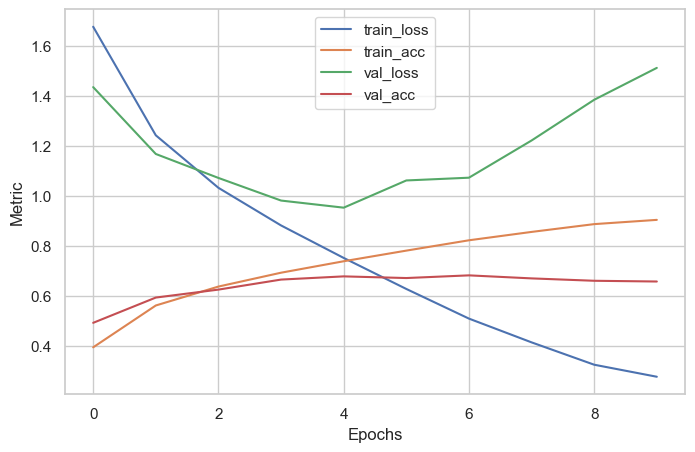

In [94]:
plt.figure(figsize=(8,5))

for metric_name, metric_value in results.items():
    plt.plot(range(len(metric_value)), metric_value, label=metric_name)
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Metric')

In [100]:
class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim, nb_classes):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, nb_classes)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        self.nb_classes = nb_classes

    def forward(self, x):
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x        

In [101]:
MLP(12,25,10)

MLP(
  (fc1): Linear(in_features=12, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=25, bias=True)
  (fc3): Linear(in_features=25, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
)

In [111]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, folder_path, labels_df, labels_to_index, transforms=None):
        self.folder_path = folder_path
        self.labels_df = labels_df
        self.labels_to_index = labels_to_index
        self.transforms = transforms #Augmentation and ToTensor
    
    def __getitem__(self, index):
        '''Read index image + label and return it'''
        input_data = self.labels_df.loc[index, :]
        image = cv2.imread(os.path.join(self.folder_path, input_data['image_name']),
        cv2.IMREAD_UNCHANGED) #Read image
        label = self.labels_to_index[input_data['label']] #Change label to number
        if self.transforms:
            image = self.transforms(image) #Run given transformations / augmentations
        image = image.flatten()
        return image, label
    def __len__(self):
        return len(self.labels)


In [114]:
training_folder = './CIFAR-10/train/'
training_dataset = CustomDataset(training_folder, training_df, labels2index)
validation_dataset = CustomDataset(training_folder, validation_df, labels2index)


In [116]:
X, Y = [], []
for i, (x, y) in enumerate(training_dataset):
    X += [x]
    Y += [y]
    if i == 10:
        break

In [119]:
import numpy as np
np.stack(X).shape

(11, 3072)

In [121]:
Y

[0, 1, 1, 2, 3, 3, 4, 5, 6, 7, 2]